# Venezuela Upstream Asset Inventory & Valuation


## Overview
### Domain:
Energy Sector / Upstream Oil & Gas

### Problem:
The Venzuela is one of the world's largest proven oil reserves, yet production capacity is highly fragmented across legacy basins and new developmental blocks. Decision-makers lack a unified, clean dataset to compare the efficiency of old vs new assets and identify where infrastructure decay is most critical. 

### Solution:
An end-to-end data pipeline that ingests raw reservoir logs, cleaning non-standardized reserve estimates, and produces a "Strategic Asset Matrix" to guide investment and operational focus

## Importing Libraries

Import Primary Modules:

In [6]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

## Question 1
Which assets are our 'Growth Giants' (massive reserves but zero current production) versus our 'Cash Cows' (high production relative to their size)?

TOP 5 GROWTH GIANTS (Longest Reserve Life):
           Reservoir_Name  Reserve_Life_Years     Status
10        Maracaibo Basin          410.958904     Mature
9             Cerro Negro          342.465753     Active
12    Barinas-Apure Basin          273.972603     Active
13           Falcon Basin          228.310502     Active
11  Lake Maracaibo Fields          219.178082  Declining


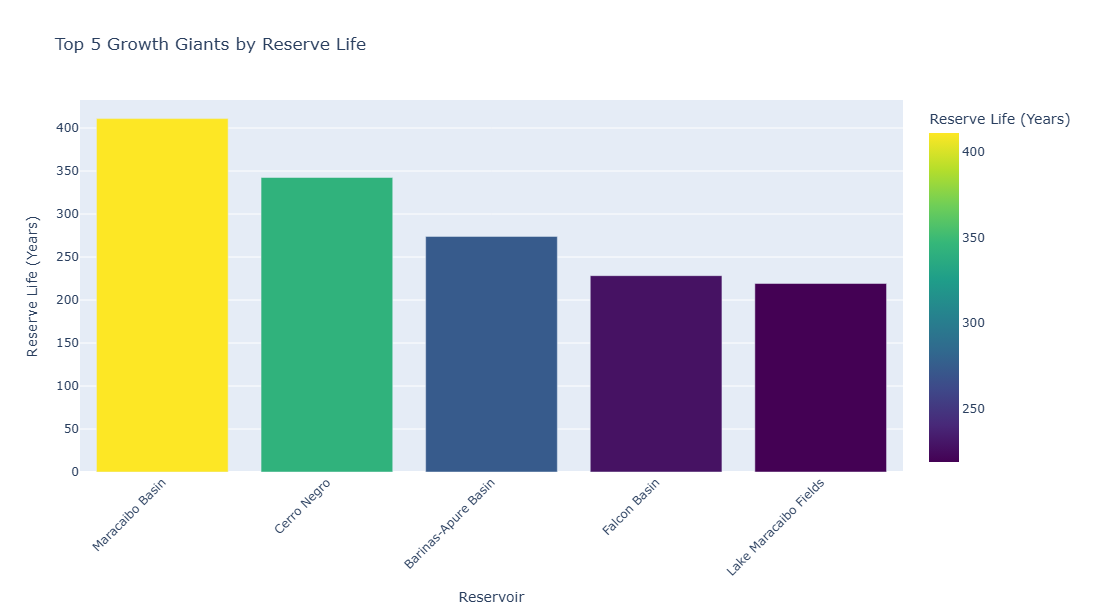

In [7]:
df = pd.read_csv('Reservoir_NameBasin_RegionLocation.csv')

# Remove rows where 'Reservoir_Name' contains 'TOTAL'
df_cleaning = df[~df['Reservoir_Name'].str.contains('TOTAL', na=False)].copy()

# Remove the aggregate 'Total' row so we don't double-count
df_clean = df[~df['Reservoir_Name'].str.contains('Total')].copy()

# Fix the 'Estimated_Recoverable' column
# We split the string by the dash, convert to float, and take the average
def clean_range(val):
    if '-' in str(val):
        parts = val.split('-')
        return (float(parts[0]) + float(parts[1])) / 2
    return float(val)

df_clean['Clean_Recoverable'] = df_clean['Estimated_Recoverable_Reserves_Billion_Barrels'].apply(clean_range)

# --- PHASE 2: CALCULATING METRICS ---
# R/P Ratio: (Reserves in Barrels) / (Annual Production in Barrels)
# Note: We multiply daily capacity by 365 to get annual production
df_clean['Reserve_Life_Years'] = (df_clean['Proven_Reserves_Billion_Barrels'] * 1e9) / (df_clean['Production_Capacity_Barrels_Day'] * 365)

# --- PHASE 3: OUTPUT INSIGHTS ---
# Let's find the top 5 'Growth Giants' (Highest life expectancy)
growth_giants = df_clean.sort_values(by='Reserve_Life_Years', ascending=False).head(5)

print("TOP 5 GROWTH GIANTS (Longest Reserve Life):")
print(growth_giants[['Reservoir_Name', 'Reserve_Life_Years', 'Status']])

# Creating the interactive plot

fig = px.bar(
    growth_giants,
    x ='Reservoir_Name',
    y = 'Reserve_Life_Years',
    color='Reserve_Life_Years',
    color_continuous_scale='Viridis',
    title='Top 5 Growth Giants by Reserve Life',
    labels={'Reserve_Life_Years': 'Reserve Life (Years)', 'Reservoir_Name': 'Reservoir'},
    hover_data=['Status'] # Adds 'Status' to the hover tooltip
)
fig.update_layout(
    width=1200,
    height=600,
    autosize=False
)
# Customize the hover appearance and layout
fig.update_traces(hovertemplate='<b>%{x}</b><br>Years: %{y:.2f}')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In our data we have clean the data using a function we made 'clean_range' which will handle string that may be messy.

# Question 2
How concentrated is our production capacity in a single region or oil grade, and what does this mean for our operational risk?

Grouping by Basin to see which region is carrying the heavy lifting for the country.

In [4]:
import plotly.express as px
# Grouping by Basin and summing the production capacity
basin_distribution = df_clean.groupby('Basin_Region')['Production_Capacity_Barrels_Day'].sum().sort_values(ascending=False)

total_capacity = basin_distribution.sum()
basin_percent = (basin_distribution / total_capacity) * 100

print("\nBasin Distribution of Production Capacity (%):")
for basin, percent in basin_percent.items():
    print(f"{basin}: {percent:.2f}%")

# We use the index (Basin names) and values (Production sums) from your basin_distribution
fig_basin = px.bar(
    x=basin_distribution.index, 
    y=basin_distribution.values,
    width=1200,   # Increased width
    height=600,   # Increased height
    color=basin_distribution.values,
    color_continuous_scale='Viridis',
    title='Production Capacity by Basin Region',
    labels={'x': 'Basin Region', 'y': 'Total Production Capacity (Barrels/Day)'}
)

# Customizing hover and layout
fig_basin.update_traces(
    hovertemplate='<b>Basin:</b> %{x}<br><b>Capacity:</b> %{y:,.0f} bbl/day'
)

# Prevents long labels from overlapping
fig_basin.update_layout(xaxis_tickangle=-45)

fig_basin.show()


Basin Distribution of Production Capacity (%):
Orinoco Belt: 71.98%
Maracaibo Basin: 13.01%
Oriente Basin: 9.43%
Apure Basin: 2.52%
Falcon Basin: 1.59%
Zulia Basin: 0.93%
Central Plains: 0.53%


Calculating the Percentage Share Raw numbers that we can use to explain to a CEO. Percentages are easy to understand. Dividing each basin's total by grand total.


Creating Pie/Donut Chart for Basin Distribution...
Orinoco Belt: 71.98%
Maracaibo Basin: 13.01%
Oriente Basin: 9.43%
Apure Basin: 2.52%
Falcon Basin: 1.59%
Zulia Basin: 0.93%
Central Plains: 0.53%


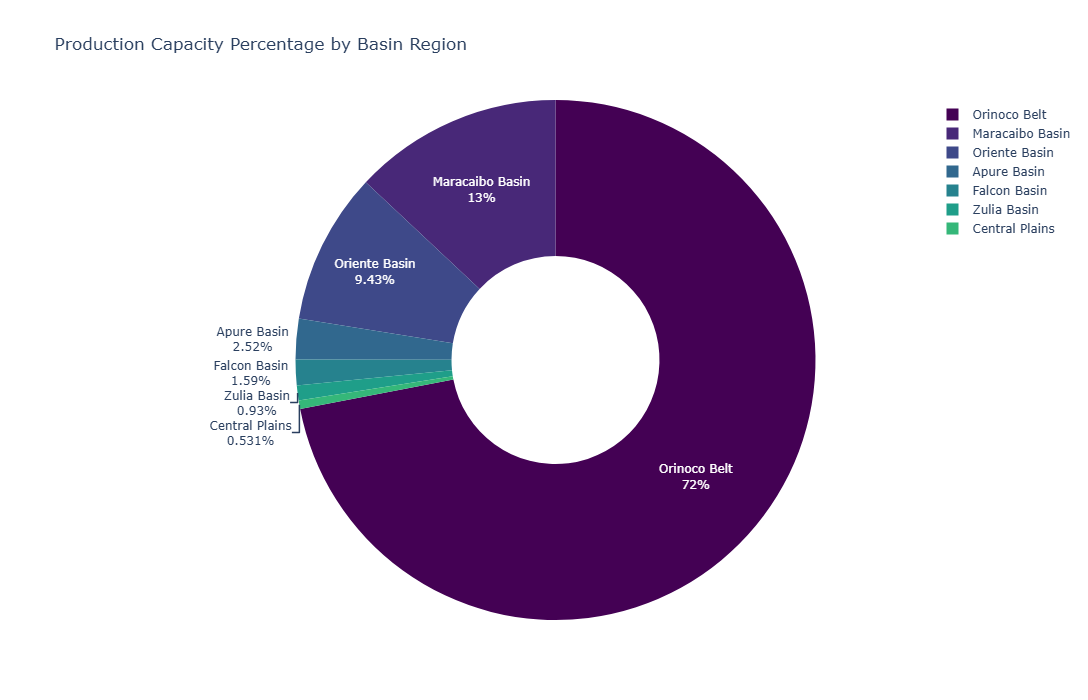

In [5]:
import plotly.express as px

print("\nCreating Pie/Donut Chart for Basin Distribution...")
for basin, percent in basin_percent.items():
    print(f"{basin}: {percent:.2f}%")

# --- STEP 1: CREATE THE PIE/DONUT CHART OBJECT ---
# We use Plotly Express (px) to map our aggregated data to a visual format.
fig_pie = px.pie(
    # 'names' defines the labels (e.g., Orinoco Belt, Maracaibo Basin)
    names=basin_distribution.index, 
    
    # 'values' defines the size of the slices (Daily Production Capacity)
    values=basin_distribution.values,
    
    # Titles should always be descriptive for stakeholders
    title='Production Capacity Percentage by Basin Region',
    
    # Setting fixed dimensions ensures the chart fits perfectly in your Notion/Portfolio
    width=900,
    height=700,
    
    # 'hole' creates the "Donut" effect. 0.4 (40%) is the industry standard for better readability
    hole=0.4, 
    
    # We use a sequential color palette (Viridis) to show a hierarchy of values
    color_discrete_sequence=px.colors.sequential.Viridis
)

# --- STEP 2: REFINE THE DATA DISPLAY (TRACES) ---
# Traces control the "skin" of the chart—how the data actually looks to the user.
fig_pie.update_traces(
    # 'textinfo' tells Plotly to show the Label and Percentage directly on the slice
    textinfo='percent+label',
    
    # 'hovertemplate' customizes the hover tooltip for clarity
    hovertemplate='<b>%{label}</b><br>Capacity: %{value:,.0f} bbl/day<br>Share: %{percent}'
)

# To display in your local environment:
fig_pie.show()

## The Pareto Analysis